# Testing vaccinated and unvaccinated population outcomes

## All measure combinations

**Note:** Vaccination scenarios operate under the assumption that the delta variant is dominant.

In [3]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt

from scseirx import analysis_functions as af

import data_creation_functions as dcf

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

Vaccine effectiveness against Delta (see [Pouwels et al. 2021](https://www.ndm.ox.ac.uk/files/coronavirus/covid-19-infection-survey/finalfinalcombinedve20210816.pdf))
* 67% effectiveness against infection 14 days after second dose of Astra Zeneca (ChAdOx1)
* 80% effectiveness against infection 21 days after second dose of Biontech Pfizer (BNT162b2)
* Viral load of vaccinated infected people seems to be similar to unvaccinated infected people ([CDC 2021](https://www.cdc.gov/mmwr/volumes/70/wr/mm7031e2.htm)).
* Vaccine effectiveness seems to drop over time ([Pouwels et al. 2021](https://www.ndm.ox.ac.uk/files/coronavirus/covid-19-infection-survey/finalfinalcombinedve20210816.pdf)) (78% effectiveness against high viral load after 90 days for Biontech Pfizer and 61% effectiveness against high viral load after 90 days for Astra Zeneca). Go for 60% effectiveness against infection and 0% effectiveness against further gransmission to be conservative. 

### Simulation settings

In [4]:
with open('params/vaccinations_measures.json', 'r') as fp:
    measures = json.load(fp)
with open('params/vaccinations_simulation_parameters.json', 'r') as fp:
    simulation_params = json.load(fp)
with open('params/vaccinations_school_characteristics.json', 'r') as fp:
    school_characteristics = json.load(fp)

### Simulation function

In [5]:
def run(params):
    '''
    Runs an ensemble of simulations and collects observable statistics. To be 
    run in parallel on many workers. Note: I/O paths and the number of runs per 
    ensemble hare hard coded here, because I only want to pass the parameter 
    values that are being screened in the simulation run to the function via the
    parallel processing interface.
    
    Parameters:
    -----------
    param_list : iterable
        Iterable that contains the values for the parameters test_type, 
        index_case, e_screen_range and r_screen_range that are passed to the
        simulation.
        
    Returns:
    --------
    row : dictionary
        Dictionary of the ensemble statistics of the observables.
    '''    

    # extract the simulation parameters from the parameter list
    N_runs, school_type, index_case, s_screen_interval, t_screen_interval,\
        student_mask, teacher_mask, half_classes, ventilation_mod,\
        student_vaccination_ratio, teacher_vaccination_ratio, \
        family_member_vaccination_ratio = params
    
    try:
        os.mkdir(join(dst, school_type))
    except FileExistsError:
        pass
    
    ttype = 'same_day_antigen'

    # run the ensemble with the given parameter combination and school type
    ensmbl_results = dcf.run_ensemble(N_runs, school_type, measures,\
            simulation_params, school_characteristics, contact_network_src,\
            dst, index_case, ttype=ttype, s_screen_interval=s_screen_interval,
            t_screen_interval=t_screen_interval, student_mask=student_mask,
            teacher_mask=teacher_mask, half_classes=half_classes,
            ventilation_mod=ventilation_mod, 
            student_vaccination_ratio=student_vaccination_ratio,
            teacher_vaccination_ratio=teacher_vaccination_ratio,
            family_member_vaccination_ratio=family_member_vaccination_ratio)
    
    ensmbl_results['school_type'] = school_type
    ensmbl_results['index_case'] = index_case
    ensmbl_results['test_type'] = ttype
    ensmbl_results['student_screen_interval'] = s_screen_interval
    ensmbl_results['teacher_screen_interval'] = t_screen_interval
    ensmbl_results['student_mask'] = student_mask
    ensmbl_results['teacher_mask'] = teacher_mask
    ensmbl_results['half_classes'] = half_classes
    ensmbl_results['ventilation_mod'] = ventilation_mod
    ensmbl_results['student_vaccination_ratio'] = student_vaccination_ratio
    ensmbl_results['teacher_vaccination_ratio'] = teacher_vaccination_ratio
    ensmbl_results['family_member_vaccination_ratio'] = family_member_vaccination_ratio
    
    return ensmbl_results

### Screening parameters

In [6]:
## parameter ranges 

# number of runs in the ensemble
# Note: this is set to 1 for testing purposes. To get properly converged 
# statistics, this has to be >= 500. Running such a high number of simulations
# will take a long time if run on just a single core. Therefore I strongly
# recommend to run the below code on several cores at once. It is easy to
# parallelize as each ensemble can be run on a different core and there are
# no interdependencies between ensembles. Results can be collected afterwards
# and evaulated together.
N_runs = 10
# different school types
school_types = ['primary', 'primary_dc', 'lower_secondary',
                'lower_secondary_dc', 'upper_secondary', 'secondary']
# specifies whether the index case will be introduced via an
# employee or a resident
index_cases = ['student', 'teacher']
# student and teacher streening intervals (in days)
s_screen_range = [None, 3, 7]
t_screen_range = [None, 3, 7]
# specifies whether teachers wear masks
student_masks = [True, False]
teacher_masks = [True, False]
half_classes = [True, False]
# specifies whether there is ventilation or not
transmission_risk_ventilation_modifiers = [1, 0.36]
# specifies the ratio of vaccinated students 
student_vaccination_ratios = [0.0, 0.5]
# specifies the ratio of vaccinated teachers
teacher_vaccination_ratios = [0.8]
family_member_vaccination_ratios = [0.6]

params = [(N_runs, i, j, k, l, m, n, o, p, q, r, s)\
              for i in school_types \
              for j in index_cases \
              for k in s_screen_range \
              for l in t_screen_range \
              for m in student_masks \
              for n in teacher_masks \
              for o in half_classes \
              for p in transmission_risk_ventilation_modifiers \
              for q in student_vaccination_ratios \
              for r in teacher_vaccination_ratios \
              for s in family_member_vaccination_ratios]

print('there are {} different parameter combinations'.format(len(params)))

there are 3456 different parameter combinations


### Run simulation

In [8]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/vaccinations/simulation_results'

number_of_cores = psutil.cpu_count(logical=True) - 2
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run, iterable=params),
                           total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case', 'test_type',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'half_classes',
              'ventilation_mod', 'student_vaccination_ratio',
              'teacher_vaccination_ratio', 'family_member_vaccination_ratio']
interesting_cols = ['index_case', 'student_vaccination_ratio', 'teacher_vaccination_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[interesting_cols + other_cols]

results.to_csv(join(dst, 'vaccinations_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 576/576 [08:09<00:00,  1.18it/s]

CPU times: user 6.7 s, sys: 479 ms, total: 7.18 s
Wall time: 8min 9s


,index_case,student_vaccination_ratio,teacher_vaccination_ratio,N_diagnostic_tests,N_family_members,N_preventive_tests,N_school_agents,R0,diagnostic_test_detected_infections_family_member,diagnostic_test_detected_infections_student,...,run,seed,student_family_member_transmissions,student_student_transmissions,student_teacher_transmissions,teacher_student_transmissions,teacher_teacher_transmissions,tests_per_day_per_agent,transmissions,undetected_infections
0,student,0.0,0.8,0.0,346.0,0.0,164.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,student,0.0,0.8,0.0,346.0,0.0,164.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,student,0.0,0.8,1.0,346.0,0.0,164.0,0.0,0.0,1.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000381,0.0,0.0


In [7]:
def set_vaccination_scenario(row):
    vaccination_scenario = 'student {:1.2f}\nteacher {:1.2f}'\
    .format(row['student_vaccination_ratio'], row['teacher_vaccination_ratio'])
    return vaccination_scenario

In [10]:
dst = '../../data/vaccinations/simulation_results'
results = pd.read_csv(join(dst, 'vaccinations_{}.csv'.format(N_runs)))
results['vaccination_scenario'] = results.apply(set_vaccination_scenario, axis=1)

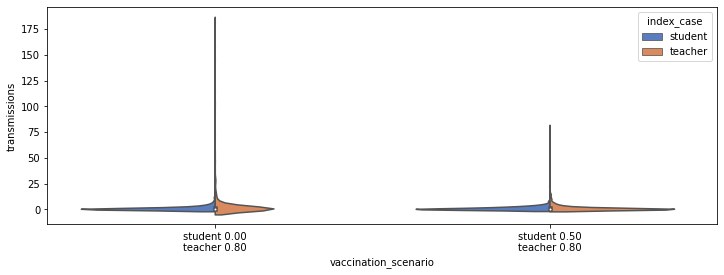

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.violinplot(x="vaccination_scenario", y="transmissions", hue="index_case",
                    data=results, palette="muted", split=True, ax=ax)
ax.tick_params(axis='x', labelsize=10)

## Minimal measure combinations

### Screening parameters

In [9]:
# number of runs in the ensemble (set to a low number so runs complete quickly
# for demonstration purposes)
N_runs = 500
# different school types (only simulate for primary schools for demonstration
# purposes)
school_types = ['secondary', 'upper_secondary', 'lower_secondary_dc', 
                'lower_secondary', 'primary_dc', 'primary']
# load the other screening parameters from file
screening_params = pd.read_csv(join('screening_params', 'vaccinations.csv'))

params = [(N_runs, st, 
           row['index_case'],
           dcf.format_none_column(row['s_screen_interval']),
           dcf.format_none_column(row['t_screen_interval']),
           row['s_mask'],
           row['t_mask'], 
           row['half_classes'],
           row['ventilation_modification'],
           row['student_vaccination_ratio'],
           row['teacher_vaccination_ratio'],
           row['family_member_vaccination_ratio']) \
           for st in school_types \
           for i, row in screening_params.iterrows()]

print('there are {} different parameter combinations'.format(len(params)))

there are 192 different parameter combinations


### Run simulation

In [18]:
%%time
# paths for data I/O
contact_network_src = '../../data/contact_networks/representative_schools'
dst = '../../data/vaccinations/simulation_results'

number_of_cores = psutil.cpu_count(logical=True)
pool = Pool(number_of_cores)

results = pd.DataFrame()
for ensmbl_results in tqdm(pool.imap_unordered(func=run, iterable=params),
                           total=len(params)):
    results = results.append(ensmbl_results, ignore_index=True)

# turn off your parallel workers 
pool.close()
    
results = results.reset_index(drop=True)
index_cols = ['school_type', 'index_case', 'test_type',
              'student_screen_interval', 'teacher_screen_interval',
              'student_mask', 'teacher_mask', 'half_classes',
              'ventilation_mod', 'student_vaccination_ratio',
              'teacher_vaccination_ratio', 'family_member_vaccination_ratio']
other_cols = [c for c in results.columns if c not in index_cols]
results = results[index_cols + other_cols]

results.to_csv(join(dst, 'vaccinations_secondary_{}.csv'\
                   .format(N_runs)), index=False)
results.head(3)

100%|██████████| 32/32 [2:11:48<00:00, 247.14s/it]  


CPU times: user 1.22 s, sys: 281 ms, total: 1.5 s
Wall time: 2h 11min 49s


,school_type,index_case,test_type,student_screen_interval,teacher_screen_interval,student_mask,teacher_mask,half_classes,ventilation_mod,student_vaccination_ratio,...,run,seed,student_family_member_transmissions,student_student_transmissions,student_teacher_transmissions,teacher_student_transmissions,teacher_teacher_transmissions,tests_per_day_per_agent,transmissions,undetected_infections
0,secondary,student,same_day_antigen,3,3,True,True,True,0.36,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333064,0.0,0.0
1,secondary,student,same_day_antigen,3,3,True,True,True,0.36,0.0,...,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.250084,2.0,0.0
2,secondary,student,same_day_antigen,3,3,True,True,True,0.36,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.266487,0.0,0.0


## Aggregate results

In [10]:
src = '../../data/vaccinations/simulation_results'
dst = src
for stype in school_types:
    print(stype)
    data = dcf.get_data(stype, src)
    data['measure'] = np.nan
    dcf.set_individual_measures(data)
    dcf.set_measure_packages(data)
    data.to_csv(join(dst, '{}_combined_ensembles.csv'.format(stype)), index=False)

secondary
upper_secondary
lower_secondary_dc
lower_secondary
primary_dc
primary


## Extract observables

In [18]:
dst = '../../data/vaccinations/simulation_results'

turnovers = {'same':0, 'one':1, 'two':2, 'three':3}
bmap = {True:'T', False:'F'}


for stype in school_types:
    print(stype)
    spath_ensmbl = join(dst,'{}'.format(stype))
    
    observables = pd.DataFrame()
    for N_runs, school_type, index_case, s_screen_interval, t_screen_interval,\
        student_mask, teacher_mask, half_classes, ventilation_mod,\
        student_vaccination_ratio, teacher_vaccination_ratio, \
        family_member_vaccination_ratio in params:
        
        ttype = 'same_day_antigen'
        
        turnover, _, test = ttype.split('_')
        turnover = turnovers[turnover]
        
        measure_string = '{}_test-{}_turnover-{}_index-{}_tf-{}_sf-{}_tmask-{}'\
        .format(stype, test, turnover, index_case[0], t_screen_interval,
                s_screen_interval, bmap[teacher_mask]) +\
                '_smask-{}_half-{}_vent-{}_tvacc-{}_svacc-{}'\
        .format(bmap[student_mask], bmap[half_classes], ventilation_mod,
                teacher_vaccination_ratio, student_vaccination_ratio)
        
        ensmbl = pd.read_csv(join(spath_ensmbl, measure_string + '.csv'))
        ensmbl = ensmbl.drop(columns=['Unnamed: 0'])
        
        row = {'test_type':test,
               'turnover':turnover,
               'index_case':index_case,
               'student_screen_interval':s_screen_interval,
               'teacher_screen_interval':t_screen_interval,
               'student_mask':student_mask,
               'teacher_mask':teacher_mask,
               'half_classes':half_classes,
               'ventilation_modification':ventilation_mod}
        
        ensmbl = ensmbl[ensmbl['infected_agents'] > 0]
        for col in ensmbl.columns:
            row.update(af.get_statistics(ensmbl, col))
        observables = observables.append(row, ignore_index=True)

    # calculate the number of tests per day and agent in the school
    observables['N_tests_per_day_per_agent'] = \
    (observables['N_diagnostic_tests_median'] + observables['N_preventive_tests_median']) /\
    observables['duration_median'] / observables['N_school_agents_median']
    
    screen_cols = ['test_type', 'turnover', 'index_case', 'student_screen_interval',
            'teacher_screen_interval', 'student_mask', 'teacher_mask',
            'half_classes', 'ventilation_modification']

    other_cols = [c for c in observables.columns if c not in screen_cols]
    observables = observables[screen_cols + other_cols]
    
    for col in ['infected_teachers_median', 'infected_students_median', 
                        'infected_family_members_median',
                        'infected_teachers_0.90', 'infected_students_0.90', 
                        'infected_family_members_0.90']:
        observables[col] = observables[col].round(0).astype(int)
    
    observables.to_csv(join(dst, '{}_observables'.format(stype) + '.csv'))

secondary
upper_secondary
lower_secondary_dc
lower_secondary
primary_dc
primary
